In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import pandas as pd
from scipy.linalg import cholesky, lstsq


In [5]:
import pyproj
pyproj.datadir.set_data_dir("/home/atmo/bin/anaconda3/envs/rmaiwald_dev/share/proj")

In [6]:
from experiments import MoreTraceGases, Sensors
from experiments import utilities as utils
from bayesinverse import Regression

In [7]:
config_path = Path(
    "/home/rmaiwald/code/Experiments/experiments/more_trace_gases/config.yaml"
)

exp = MoreTraceGases(config_path)
# basic_setup.run()


sensors 0.003136560320854187


/home/rmaiwald/code/Experiments/experiments/shared/emissions.py:301: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  tno_points_gdf = pickle.load(file)


emissions 1.926439791917801
transport 6.4335597306489944


In [8]:
exp.sensors_config

{'n_sensors': 10, 'height': 0, 'noise': 1.0, 'seed': 42, 'time': 120}

In [9]:
# CO2 sensors
exp.sensors_co2 = Sensors(exp.sensors_config)

# CO sensors
co_config = exp.sensors_config
co_config["noise"] = .002
co_config["seed"] = 5
exp.sensors_co = Sensors(exp.sensors_config)

In [10]:
exp.K = exp.transport.get_transport(
    n_sensors=exp.sensors_co2.n_sensors + exp.sensors_co.n_sensors,
    sensors_index=utils.concatenate_indices(
        exp.sensors_co2.get_index(), exp.sensors_co.get_index()
    ),
    emissions=exp.emissions,
    n_processes=32
)

# Multiply with emission factor
em_factors_co = exp.emissions.get_emission_factors()[exp.emissions.mask]
em_factors = xr.DataArray(em_factors_co, dims=["source_group"])
em_factors
# sensor, time_measurement, source_group, time_state
exp.K[exp.sensors_co2.n_sensors:,] *= em_factors

loop start 70.29214477539062
loop end 70.35231213271618


/home/rmaiwald/code/Experiments/experiments/shared/emissions.py:374: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  tno_points_gdf = pickle.load(file)


In [11]:
noise = xr.concat(
    [exp.sensors_co2.get_noise(), exp.sensors_co.get_noise()], dim="sensor"
)
covariance = xr.concat(
    [exp.sensors_co2.get_covariance(), exp.sensors_co.get_covariance()], dim="sensor"
)

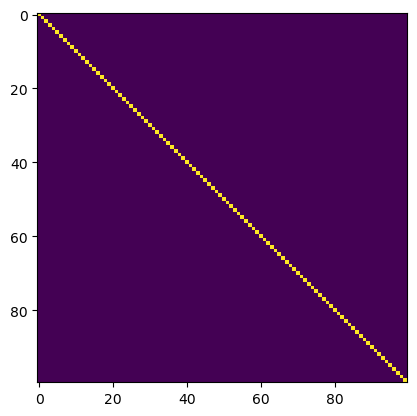

In [12]:
plt.imshow(utils.stack_xr(exp.emissions.prior_covariance)[:100, :100])

In [13]:
exp.reg = Regression(
    y=utils.stack_xr(
        exp.K.isel(sensor=slice(exp.sensors_co2.n_sensors)) @ exp.emissions.truth
        + noise.isel(sensor=slice(exp.sensors_co2.n_sensors))
    ).values,
    K=utils.stack_xr(exp.K.isel(sensor=slice(exp.sensors_co2.n_sensors))).values,
    x_prior=utils.stack_xr(exp.emissions.prior).values,
    x_covariance=utils.stack_xr(exp.emissions.prior_covariance).values,
    y_covariance=utils.stack_xr(covariance.isel(sensor=slice(exp.sensors_co2.n_sensors))).values,
)
x_est, res, rank, s = exp.reg.fit()
posterior = exp.emissions.to_xr(x_est)


In [14]:
exp.reg_combined = Regression(
    y=utils.stack_xr(exp.K @ exp.emissions.truth + noise).values,
    K=utils.stack_xr(exp.K).values,
    x_prior=utils.stack_xr(exp.emissions.prior).values,
    x_covariance=utils.stack_xr(exp.emissions.prior_covariance).values,
    y_covariance=utils.stack_xr(covariance).values,
)
x_est, res, rank, s = exp.reg_combined.fit()
posterior_combined = exp.emissions.to_xr(x_est)

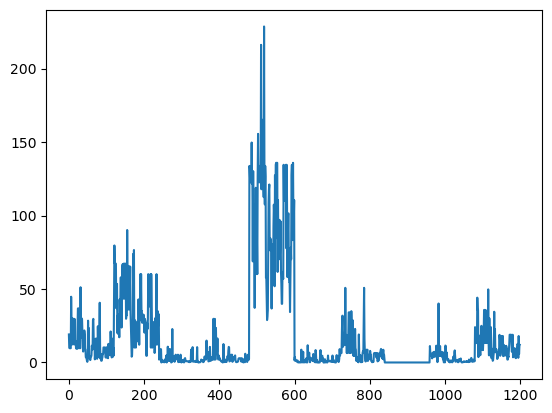

In [15]:
# plt.plot(utils.stack_xr(exp.K).values.sum(axis=1))
plt.plot(
    utils.stack_xr(exp.K.isel(sensor=slice(exp.sensors_co2.n_sensors))).values.sum(
        axis=1
    )
)


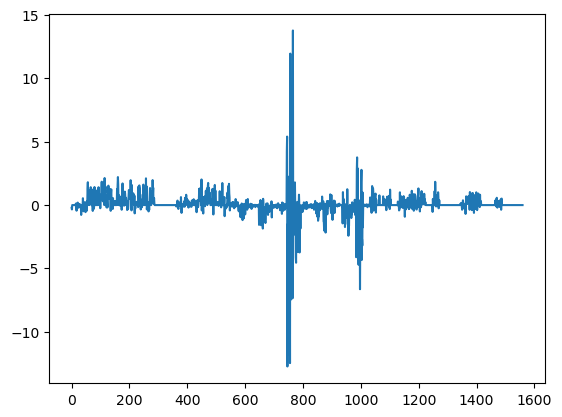

In [16]:
plt.plot(utils.stack_xr(posterior_combined - posterior))

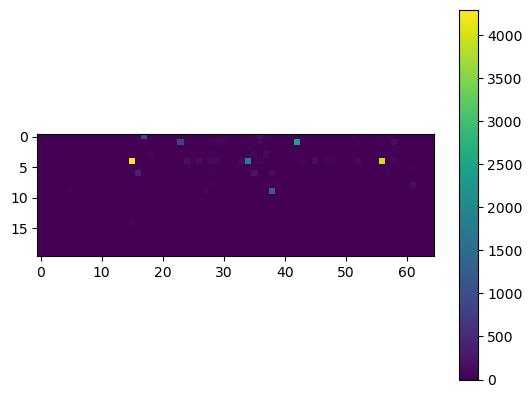

In [17]:
im = plt.imshow(exp.K.sum(dim=["time_state", "time_measurement"]))
plt.colorbar()

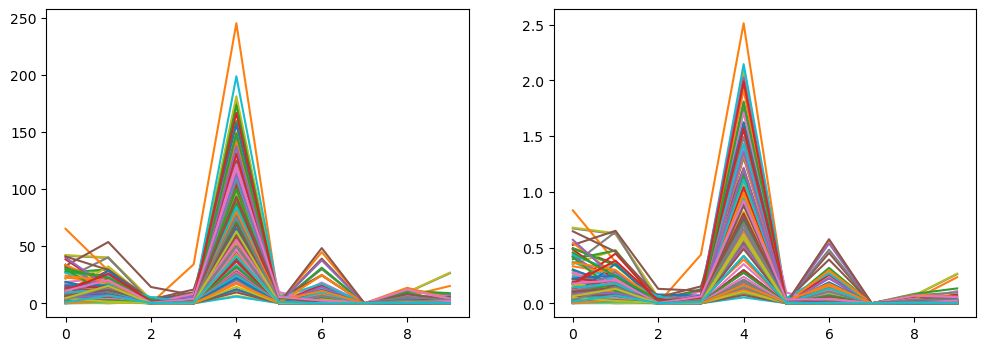

In [18]:
plt.subplots(1, 2, figsize=(12, 4))
plt.subplot(121)
plt.plot((exp.K @ exp.emissions.truth)[:exp.sensors_co2.n_sensors])
plt.subplot(122)
plt.plot((exp.K @ exp.emissions.truth)[exp.sensors_co2.n_sensors:])
pass

In [19]:
true_emissions = exp.emissions.get_absolute()[exp.emissions.mask]
posterior = utils.unstack_xr(posterior) * true_emissions
# To xarray
posterior_covariance = exp.emissions.to_xr(exp.reg.get_posterior_covariance())
# Multiply with emissions
posterior_covariance = utils.unstack_xr(posterior_covariance) * true_emissions
posterior_covariance = posterior_covariance * true_emissions.rename(
    source_group="source_group_2"
)


In [20]:
posterior_combined = utils.unstack_xr(posterior_combined) * true_emissions
# To xarray
posterior_combined_covariance = exp.emissions.to_xr(exp.reg_combined.get_posterior_covariance())
# Multiply with emissions
posterior_combined_covariance = utils.unstack_xr(posterior_combined_covariance) * true_emissions
posterior_combined_covariance = posterior_combined_covariance * true_emissions.rename(
    source_group="source_group_2"
)


In [21]:
posterior_covariance

<xarray.DataArray (source_group: 65, time_state: 24, source_group_2: 65,
                   time_state_2: 24)>
array([[[[ 1.81405677e+09,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [-7.39361975e+04,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 6.51944930e+04,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         ...,
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

        [[ 0.00000000e+00,  1.93468010e+09,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  8.27401439e+04,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00, -1.04448905e+06,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
...
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  2.14475442e+07,  0.00000000e+00]],

        [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         ...,
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  2.14475442e+07]]]])
Coordinates:
  * source_group_2  (source_group_2) int64 1 2 3 4 5 6 7 ... 63 64 65 66 67 68
  * time_state_2    (time_state_2) int64 0 1 2 3 4 5 6 ... 17 18 19 20 21 22 23
  * source_group    (source_group) int64 1 2 3 4 5 6 7 ... 62 63 64 65 66 67 68
  * time_state      (time_state) int64 0 1 2 3 4 5 6 7 ... 17 18 19 20 21 22 23

In [23]:
exp.data["posterior"] = posterior
exp.data["posterior_combined"] = posterior_combined
exp.data["posterior_covariance"] = posterior_covariance
exp.data["posterior_combined_covariance"] = posterior_combined_covariance
exp.pickle_data()

Move to plotting...

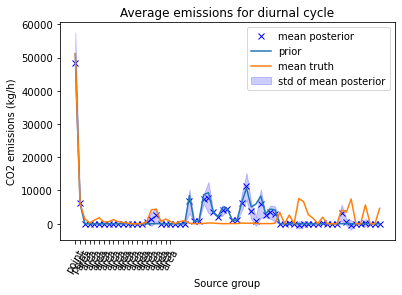

In [ ]:
mean = utils.unstack_xr(posterior).mean("time_state")
std = utils.unstack_xr(posterior).std("time_state")
line = plt.plot(mean, "bx", label="mean posterior")[0]
plt.fill_between(
    range(len(mean)),
    mean - std,
    mean + std,
    alpha=0.2,
    color=line._color,
    label="std of mean posterior",
)

plt.plot(exp.emissions.prior_absolute.mean("time_state"), label="prior")
plt.plot(exp.emissions.truth_absolute.mean("time_state"), label="mean truth")
plt.xlabel("Source group")
plt.ylabel("CO2 emissions (kg/h)")
plt.legend()
plt.xticks(np.arange(21), ["point"] * 2 + ["area"] * 19, rotation=60)
plt.title("Average emissions for diurnal cycle")
pass


In [ ]:
var = []
for coor, sub_arr in posterior_covariance.groupby('time_state'):
    cov = sub_arr.sel(time_state_2=coor).isel(source_group=slice(1, None))
    var.append(utils.var_of_sum(cov))

In [ ]:
var_combined = []
for coor, sub_arr in posterior_combined_covariance.groupby('time_state'):
    cov = sub_arr.sel(time_state_2=coor).isel(source_group=slice(1, None))
    var_combined.append(utils.var_of_sum(cov))

RMSE: <xarray.DataArray ()>
array(28915.53231995)
RMSE with CO: <xarray.DataArray ()>
array(29598.99908415)


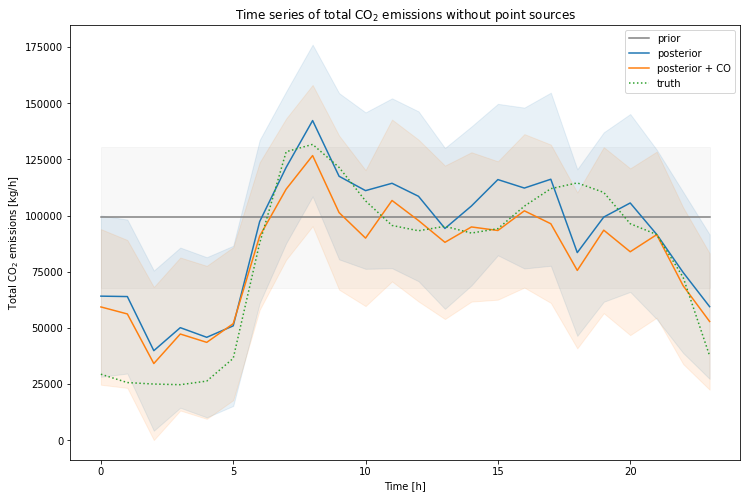

In [ ]:
plt.figure(figsize=(12, 8))

mean_prior = exp.emissions.prior_absolute.isel(source_group=slice(1, None)).sum(
    "source_group"
)
std_prior = np.sqrt(
    (
        exp.emissions.prior_variance.isel(source_group=slice(1, None))
        * exp.emissions.get_absolute()[exp.emissions.mask] ** 2
    ).sum("source_group")
)
line = plt.plot(mean_prior, color="grey", label="prior")[0]
plt.fill_between(
    range(len(mean_prior)),
    mean_prior - std_prior,
    mean_prior + std_prior,
    alpha=0.05,
    color=line._color,
)

mean = posterior.isel(source_group=slice(1, None)).sum("source_group")
std = np.sqrt(var)
line = plt.plot(mean, "-", label="posterior")[0]
rmse = np.sqrt(np.mean((mean - mean_prior)**2))
plt.fill_between(range(len(mean)), mean - std, mean + std, alpha=0.1, color=line._color)

mean = posterior_combined.isel(source_group=slice(1, None)).sum("source_group")
std = np.sqrt(var_combined)
line = plt.plot(mean, "-", label="posterior + CO")[0]
rmse_co = np.sqrt(np.mean((mean - mean_prior)**2))
plt.fill_between(range(len(mean)), mean - std, mean + std, alpha=0.1, color=line._color)


plt.plot(
    exp.emissions.truth_absolute.isel(source_group=slice(1, None)).sum("source_group"),
    ":",
    label="truth",
)
plt.legend()
# print((mean - mean_prior).mean())
plt.title(r"Time series of total CO$_2$ emissions without point sources")
plt.xlabel(r"Time [h]")
plt.ylabel(r"Total CO$_2$ emissions [kg/h]")
plt.savefig(
    "/home/rmaiwald/results/preliminary/more_trace_gases_timeseries_no_point_sources"
)
print("RMSE: {}".format(rmse))
print("RMSE with CO: {}".format(rmse_co))

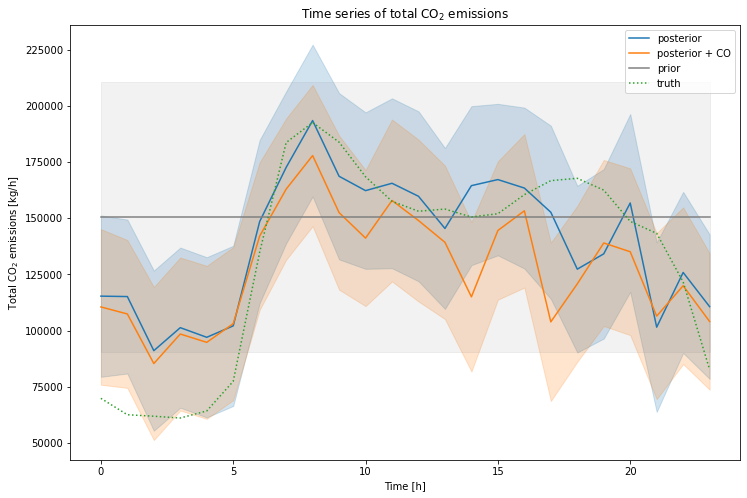

In [ ]:
plt.figure(figsize=(12, 8))
mean = posterior.sum("source_group")
std = np.sqrt(var)
line = plt.plot(mean, "-", label="posterior")[0]
plt.fill_between(range(len(mean)), mean - std, mean + std, alpha=0.2, color=line._color)

mean = posterior_combined.sum("source_group")
std = np.sqrt(var_combined)
line = plt.plot(mean, "-", label="posterior + CO")[0]
plt.fill_between(range(len(mean)), mean - std, mean + std, alpha=0.2, color=line._color)

mean_prior = exp.emissions.prior_absolute.sum(
    "source_group"
)
std_prior = np.sqrt(
    (
        exp.emissions.prior_variance
        * exp.emissions.get_absolute()[exp.emissions.mask] ** 2
    ).sum("source_group")
)
line = plt.plot(mean_prior, color="grey", label="prior")[0]
plt.fill_between(
    range(len(mean_prior)),
    mean_prior - std_prior,
    mean_prior + std_prior,
    alpha=0.1,
    color=line._color,
)

plt.plot(
    exp.emissions.truth_absolute.sum("source_group"),
    ":",
    label="truth",
)
plt.legend()
# print((mean - mean_prior).mean())
plt.title(r"Time series of total CO$_2$ emissions")
plt.xlabel(r"Time [h]")
plt.ylabel(r"Total CO$_2$ emissions [kg/h]")
plt.savefig("/home/rmaiwald/results/preliminary/more_trace_gases_timeseries")

<xarray.DataArray ()>
array(-17651.48670963)


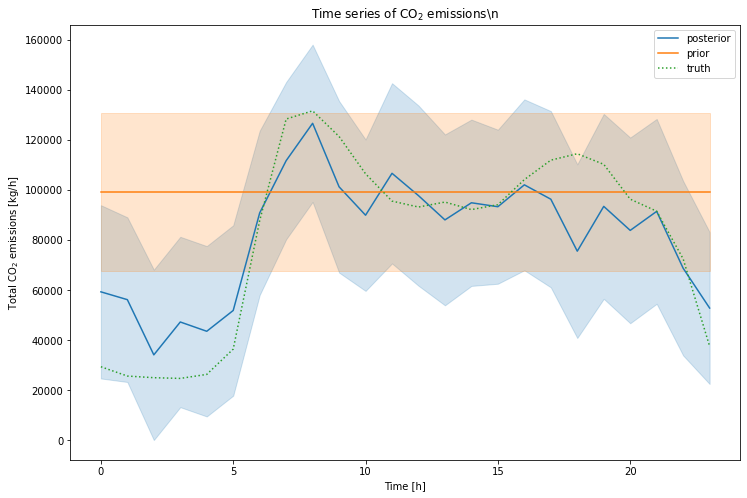

In [ ]:
plt.figure(figsize=(12, 8))
mean = posterior_combined.isel(source_group=slice(1, None)).sum("source_group")
std = np.sqrt(var_combined)
line = plt.plot(mean, "-", label="posterior")[0]
plt.fill_between(range(len(mean)), mean - std, mean + std, alpha=0.2, color=line._color)

mean_prior = exp.emissions.prior_absolute.isel(source_group=slice(1, None)).sum(
    "source_group"
)
std_prior = np.sqrt(
    (
        exp.emissions.prior_variance.isel(source_group=slice(1, None))
        * exp.emissions.get_absolute()[exp.emissions.mask] ** 2
    ).sum("source_group")
)
line = plt.plot(mean_prior, label="prior")[0]
plt.fill_between(
    range(len(mean_prior)),
    mean_prior - std_prior,
    mean_prior + std_prior,
    alpha=0.2,
    color=line._color,
)

plt.plot(
    exp.emissions.truth_absolute.isel(source_group=slice(1, None)).sum("source_group"),
    ":",
    label="truth",
)
plt.legend()
print((mean - mean_prior).mean())
plt.title(r"Time series of CO$_2$ emissions\n")
plt.xlabel(r"Time [h]")
plt.ylabel(r"Total CO$_2$ emissions [kg/h]")
plt.savefig("/home/rmaiwald/results/preliminary/more_trace_gases_timeseries")

In [ ]:
re

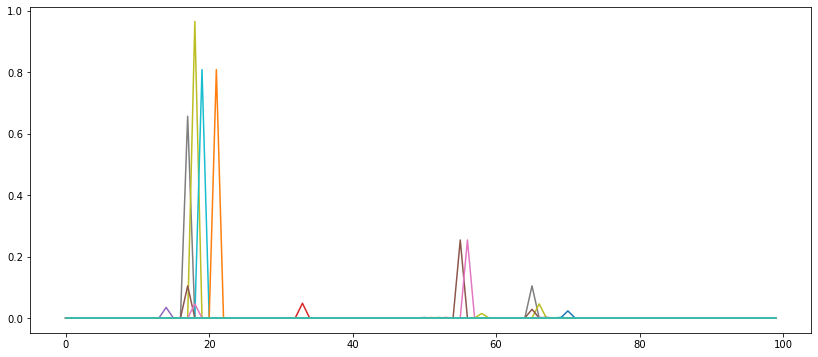

In [ ]:
plt.figure(figsize=(14, 6))
averaging_kernel = exp.reg.get_averaging_kernel()
# for i in range(averaging_kernel.shape[0]):
for i in range(100):
    kernel = averaging_kernel[i]
    plt.plot(kernel[:100], label=kernel.sum())
    # print(kernel.sum())
# plt.legend()


In [ ]:
posterior

<xarray.DataArray (source_group: 65, time_state: 24)>
array([[ 5.11415525e+04,  5.11415525e+04,  5.11415525e+04, ...,
         3.08851447e+04,  5.11415525e+04,  5.11415525e+04],
       [ 6.08046221e+03,  6.08046221e+03,  6.08046221e+03, ...,
         6.08046221e+03,  6.08046221e+03,  6.08046221e+03],
       [ 6.06843261e-12,  3.34986343e+00, -3.94740540e+01, ...,
        -3.84139928e+01, -1.35198833e+02,  5.54562747e+00],
       ...,
       [-0.00000000e+00, -0.00000000e+00, -0.00000000e+00, ...,
        -0.00000000e+00, -0.00000000e+00, -0.00000000e+00],
       [-0.00000000e+00, -0.00000000e+00, -0.00000000e+00, ...,
        -0.00000000e+00, -0.00000000e+00, -0.00000000e+00],
       [-0.00000000e+00, -0.00000000e+00, -0.00000000e+00, ...,
        -0.00000000e+00, -0.00000000e+00, -0.00000000e+00]])
Coordinates:
  * source_group  (source_group) int64 1 2 3 4 5 6 7 8 ... 62 63 64 65 66 67 68
  * time_state    (time_state) int64 0 1 2 3 4 5 6 7 ... 16 17 18 19 20 21 22 23

In [ ]:
exp.emissions.prior_covariance  

<xarray.DataArray (source_group: 65, time_state: 24, time_state_2: 24,
                   source_group_2: 65)>
array([[[[1., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [1., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [1., 0., 0., ..., 0., 0., 0.],
         ...,
...
         ...,
         [0., 0., 0., ..., 0., 0., 1.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 1.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 1.]]]])
Coordinates:
  * source_group_2  (source_group_2) int64 1 2 3 4 5 6 7 ... 63 64 65 66 67 68
  * source_group    (source_group) int64 1 2 3 4 5 6 7 ... 62 63 64 65 66 67 68
Dimensions without coordinates: time_state, time_state_2

In [ ]:
averaging_kernel = exp.reg.get_averaging_kernel()
averaging_kernel = xr.DataArray(
    averaging_kernel,
    dims=["state", "state_2"],
    coords=utils.stack_xr(exp.emissions.prior_covariance).coords,
)

averaging_kernel = utils.unstack_xr(averaging_kernel)
averaging_kernel = (
    averaging_kernel
    * true_emissions
    / true_emissions.rename(source_group="source_group_2")
    # / (true_emissions**2).sum()
)
averaging_kernel = utils.stack_xr(averaging_kernel)


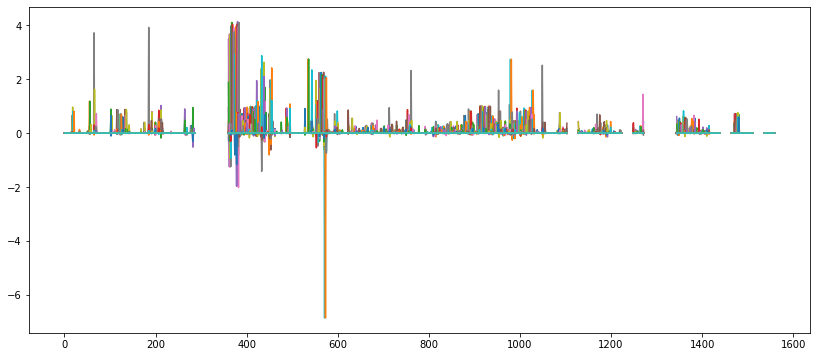

In [ ]:
plt.figure(figsize=(14, 6))
# for i in range(averaging_kernel.shape[0]):
for i in range(averaging_kernel.shape[0]):
    kernel = averaging_kernel[i]
    plt.plot(kernel, label=kernel.sum())
    # print(kernel.sum())
# plt.legend()


In [ ]:
for i in range(len(averaging_kernel["time_state"])):
    kernel = averaging_kernel.isel(time_state=i, time_state_2=i)
    plt.plot(kernel, label=kernel.sum())


ValueError: Dimensions {'time_state', 'time_state_2'} do not exist. Expected one or more of ('state', 'state_2')

In [ ]:
print(np.where(averaging_kernel > 1., 1, 0).sum())
plt.imshow(np.where(averaging_kernel > 1., 1, 0))

In [ ]:
l = cholesky(np.diag(utils.stack_xr(exp.emissions.prior_covariance).values))
im = plt.imshow(l)
plt.colorbar(im)

In [ ]:
(utils.stack_xr(exp.emissions.truth_absolute).values
* exp.reg.get_posterior_covariance()
* utils.stack_xr(exp.emissions.truth_absolute).values.T).min()

In [ ]:
(utils.stack_xr(exp.emissions.truth_absolute).values
* exp.reg.get_posterior_covariance()
* utils.stack_xr(exp.emissions.truth_absolute).values.T).max()

In [ ]:
im = plt.imshow(
    exp.reg.get_posterior_covariance()
)
plt.colorbar(im)


In [ ]:
im = plt.imshow(
    utils.stack_xr(exp.emissions.truth_absolute).values
    * exp.reg.get_posterior_covariance()
    * utils.stack_xr(exp.emissions.truth_absolute).values.T
)
plt.colorbar(im)


In [ ]:
plt.figure(figsize=(12,12))

plt.imshow(exp.reg.get_correlation())

In [24]:
exp.reg.get_information_content(), exp.reg.get_dof_signal(), exp.reg.get_dof_noise()

/net/dsvr-01/home/rmaiwald/code/BayesInverse/bayesinverse/regression.py:496: RuntimeWarning: divide by zero encountered in log
  return -0.5 * np.log(


(inf, 536.7747775877103, 1023.2252224122891)

In [26]:
exp.reg.get_error_reduction(), exp.reg.get_relative_gain(exp.emissions.x)

TypeError: get_relative_gain() missing 1 required positional argument: 'x_truth'

In [ ]:
-0.5 * np.log(np.abs(np.linalg.det(exp.reg.get_posterior_covariance() @ exp.reg.get_x_covariance_inv())))

In [ ]:
im = plt.imshow(exp.reg.get_posterior_covariance() @ exp.reg.get_x_covariance_inv())
plt.colorbar(im)